In [158]:
# Import all libraries needed for the tutorial

# General syntax to import specific functions in a library: 
##from (library) import (specific library function)
from pandas import DataFrame, read_csv

# General syntax to import a library but no functions: 
##import (library) as (give the library a nickname/alias)
import matplotlib.pyplot as plt
import pandas as pd #this is how I usually import pandas
import sys #only needed to determine Python version number
import matplotlib #only needed to determine Matplotlib version number

from datetime import timedelta

# Enable inline plotting
%matplotlib inline

print('Python version ' + sys.version)
print('Pandas version ' + pd.__version__)
print('Matplotlib version ' + matplotlib.__version__)

def format_csv_df(df, year):
    """ Recibe el dataframe con los datos 'crudos' del kimai y 
        devuelve un nuevo dataframe con las columnas que nos interesan para el análisis:
        
        | Entrada | Salida | Customer | Project | Activity | Description | socio | Duration |
    """
    #TODO: Normalizar los nombres de las columnas.
    
    # Cambiamos el formato de la columna 'Día', 'Entrada' y 'Salida'
    df['Día'] = pd.to_datetime(df['Día'], format='%d.%m.')
    df['Entrada'] = pd.to_datetime(df['Entrada'], format='%H:%M')
    df['Salida'] = pd.to_datetime(df['Salida'], format='%H:%M')
    # Cambiamos los años de las columnas tipo datetime por el año actual.
    df['Entrada'] = df['Entrada'].apply(lambda dt: dt.replace(year=year))
    df['Día'] = df['Día'].apply(lambda dt: dt.replace(year=year))
    df['Salida'] = df['Salida'].apply(lambda dt: dt.replace(year=year))
    # Actualizamos los días de las columnas 'Entrada' y 'Salida' según la columna 'Día'.
    df['Entrada'] = pd.to_datetime(df['Día'].dt.date.apply(str) + ' ' + df['Entrada'].dt.hour.apply(str) + ':' + df['Entrada'].dt.minute.apply(str))
    df['Salida'] = pd.to_datetime(df['Día'].dt.date.apply(str) + ' ' + df['Salida'].dt.hour.apply(str) + ':' + df['Salida'].dt.minute.apply(str))

    # Creamos un nuevo DataFrame con las columnas que nos interesan.
    new = df.filter(['Entrada', 'Salida', 'Customer', 'Project', 'Activity', 'Description', 'Nombre de usuario'])
    # Cambiamos el nombre de la columna 'Nombre de usuario' y calculamos la duración del evento.
    new.rename(columns={'Nombre de usuario': 'socio'}, inplace=True)
    # Hay campos que por trabajar desde las 23:00 y pasadas las 00:00, el timedelta de 'Duration' da negativo.
    # Para que la cuenta de bien, hay que cambiar el día por el siguiente en la columna de 'Salida'.
    new.loc[new.Entrada > new.Salida, 'Salida'] = new['Salida'] + timedelta(days=1)
    new['Duration'] = new['Salida'] - new['Entrada']

    return new

def get_totals(dataframe, working_days):
    """ Procesa un dataframe con los datos requeridos por el análisis, para obtener los totales por socio
        y poder graficar lo trabajado vs. lo esperado por cada socio en una cierta cantidad de días hábiles.
    """
    #TODO: parametrizar mejor la cantidad de horas de cada socio.
    
    # Creamos un nuevo DataFrame con los totales x socio.
    total = dataframe[['socio', 'Duration']].groupby('socio').aggregate(sum)
    #FIXME: que se cargue dinámicamente según lo que se necesite
    if len(total) == 8:
        total['diario'] = [
            pd.Timedelta('8h'), 
            pd.Timedelta('6h'), 
            pd.Timedelta('4h'), 
            pd.Timedelta('8h'), 
            pd.Timedelta('5h30m'), 
            pd.Timedelta('6h'), 
            pd.Timedelta('7h'), 
            pd.Timedelta('5h'), 
        ]
    elif len(total) == 7:
        total['diario'] = [
            pd.Timedelta('8h'), 
            pd.Timedelta('6h'), 
            pd.Timedelta('4h'), 
            pd.Timedelta('8h'), 
            pd.Timedelta('5h30m'), 
            pd.Timedelta('6h'), 
            pd.Timedelta('5h'), 
        ]
    elif len(total) == 6:
        total['diario'] = [
            pd.Timedelta('8h'), 
            pd.Timedelta('4h'), 
            pd.Timedelta('8h'), 
            pd.Timedelta('5h30m'), 
            pd.Timedelta('6h'), 
            pd.Timedelta('5h'), 
        ]
    else:
        raise ValueError('No se pudo cargar la columna "diario"', len(total))
    total['habiles'] = working_days
    total['esperado'] = total['diario'] * total['habiles']
    total['porcentaje'] = total['Duration'].astype('timedelta64[m]').astype(int) / total['esperado'].astype('timedelta64[m]').astype(int) * 100
    # Convertimos las duraciones en minutos y a enteros para poder graficar
    total['Duration_int'] = total['Duration'].astype('timedelta64[m]').astype(int)
    total['esperado_int'] = total['esperado'].astype('timedelta64[m]').astype(int)
    total.rename(columns={'Duration_int': 'trabajado'}, inplace=True)
    return total

def process_months(df, calendar):
    """ Devuelve un diccionario con los meses como claves y los valores son los dataframes de los registros del kimai. 
    """
    month_df = dict()
    for month, data in calendar['month'].items():
        month_df[month] = df.loc[(df['Entrada'] >= data['begin']) & (df['Entrada'] < data['end'])]
    return month_df

def totals_per_month(dataframe_dict, calendar):
    data = dict()
    for month, dataframe in dataframe_dict.items():
        if dataframe.empty:
            continue
        data[month] = get_totals(dataframe=dataframe, working_days=calendar['month'][month]['days'])
    return data

Python version 3.6.5 (default, Apr  4 2018, 15:09:05) 
[GCC 7.3.1 20180130 (Red Hat 7.3.1-2)]
Pandas version 0.20.3
Matplotlib version 2.0.2


In [128]:
calendar = {
    'year': 2017,
    'month': {
        'jan': {'begin': '2017-01-01 00:00', 'end': '2017-02-01 00:00', 'days': 0},
        'feb': {'begin': '2017-02-01 00:00', 'end': '2017-03-01 00:00', 'days': 0},
        'mar': {'begin': '2017-03-01 00:00', 'end': '2017-04-01 00:00', 'days': 0},
        'apr': {'begin': '2017-04-01 00:00', 'end': '2017-05-01 00:00', 'days': 0},
        'may': {'begin': '2017-05-01 00:00', 'end': '2017-06-05 00:00', 'days': 23},
        'jun': {'begin': '2017-06-05 00:00', 'end': '2017-07-03 00:00', 'days': 19},
        'jul': {'begin': '2017-07-03 00:00', 'end': '2017-08-07 00:00', 'days': 25},
        'ago': {'begin': '2017-08-07 00:00', 'end': '2017-09-04 00:00', 'days': 19},
        'sep': {'begin': '2017-09-04 00:00', 'end': '2017-10-02 00:00', 'days': 20},
        'oct': {'begin': '2017-10-02 00:00', 'end': '2017-11-06 00:00', 'days': 24},
        'nov': {'begin': '2017-11-06 00:00', 'end': '2017-12-04 00:00', 'days': 19},
        'dec': {'begin': '2017-12-04 00:00', 'end': '2018-01-01 00:00', 'days': 18},
    }
}
# Cargamos los datos de las horas cargadas en Kimai.
location = 'kimai_20170501-20171231.csv'
df = pd.read_csv(location)

In [132]:
new = format_csv_df(df=df, year=calendar['year'])
wd = sum([month['days'] for month in calendar['month'].values()])
total = get_totals(dataframe=new, working_days=wd)
total

,Duration,diario,habiles,esperado,porcentaje,trabajado,esperado_int
socio,,,,,,,
abrunacci,53 days 07:13:00,08:00:00,167,55 days 16:00:00,95.749750,76753,80160
acuervo,25 days 08:28:00,06:00:00,167,41 days 18:00:00,60.725216,36508,60120
cuberti,22 days 21:58:00,04:00:00,167,27 days 20:00:00,82.330339,32998,40080
ddebonis,53 days 18:56:00,08:00:00,167,55 days 16:00:00,96.626747,77456,80160
hbrunacci,33 days 01:54:00,05:30:00,167,38 days 06:30:00,86.434404,47634,55110
lcolombo,41 days 14:16:00,06:00:00,167,41 days 18:00:00,99.627412,59896,60120
mmesmer,20 days 18:15:00,07:00:00,167,48 days 17:00:00,42.621899,29895,70140
nespino,46 days 05:00:00,05:00:00,167,34 days 19:00:00,132.814371,66540,50100


In [105]:
# Guardamos el DataFrame en un CSV.
# new.to_csv('kimai_proccessed_with_pandas.csv', index=False)

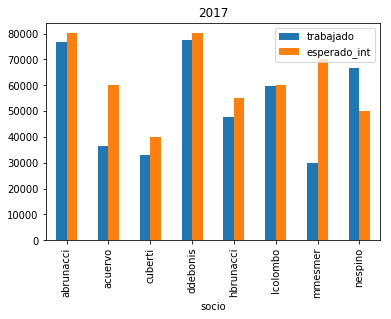

In [130]:
g_total = total[['trabajado', 'esperado_int']].plot(kind='bar', title=calendar['year'])

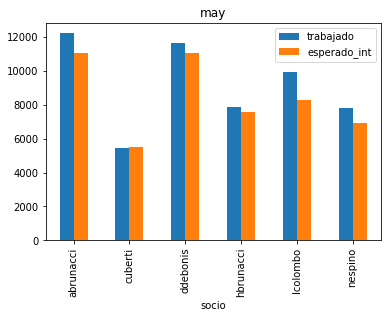

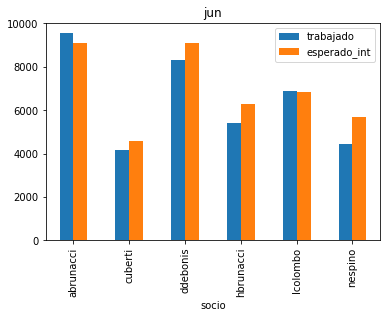

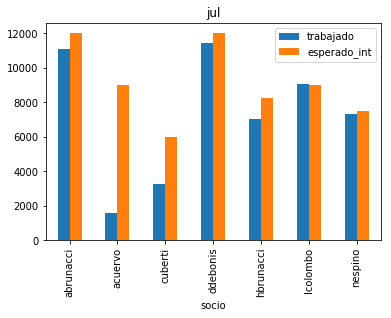

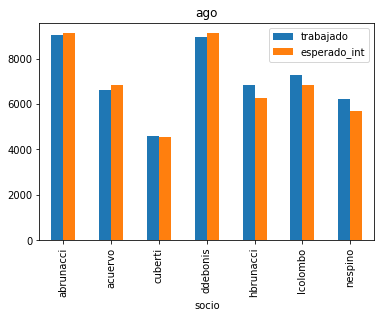

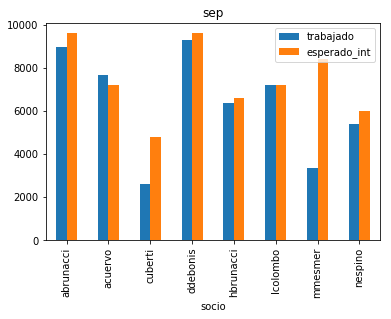

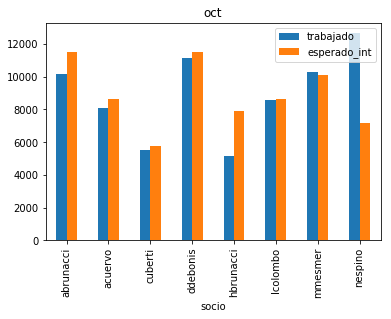

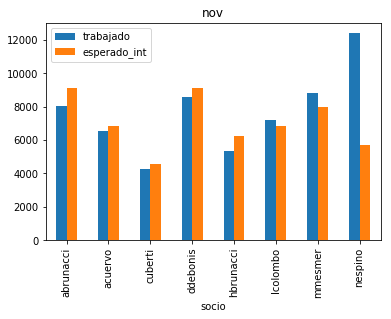

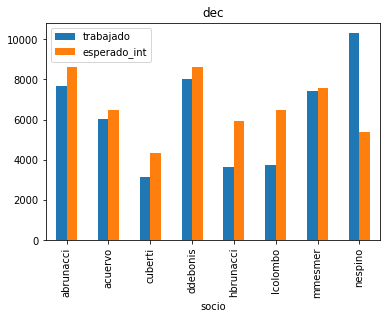

In [160]:
data = process_months(df=new, calendar=calendar)
months_totals = totals_per_month(dataframe_dict=data, calendar=calendar)

for month, data in months_totals.items():
    g_total = data[['trabajado', 'esperado_int']].plot(kind='bar', title=month)

In [161]:
# Creamos un nuevo DataFrame con las columnas que nos interesan
customer = new.filter(['Customer', 'socio', 'Duration'])
# Convertimos la duración en minutos y a entero para poder sumar y graficar.
customer['Duration'] = customer['Duration'].astype('timedelta64[m]').astype(int)
customer = customer.reset_index().groupby(['Customer', 'socio']).sum()
# Eliminamos la columna Index que no tiene información relevante
del customer['index']
customer

Duration
Customer                            socio              
AllAccess                           nespino         642
Andes Líneas Aéreas                 abrunacci     19308
                                    ddebonis      21356
                                    lcolombo       2285
                                    mmesmer         330
                                    nespino          75
Aptage                              nespino       27551
Betterez                            abrunacci     22791
Bitson                              abrunacci     23649
                                    acuervo       36508
                                    cuberti       32998
                                    ddebonis      50285
                                    hbrunacci     36127
                                    lcolombo      45896
                                    mmesmer        9165
                                    nespino       15009
Cise                                abrunacci        10
                                    hbrunacci        84
CoopeViajes                         lcolombo        185
Don Bosco Bernal                    hbrunacci       795
ECSA                                abrunacci     10965
                                    ddebonis       5815
                                    hbrunacci      9908
                                    lcolombo       8055
                                    mmesmer       20400
                                    nespino        6475
El Condominio                       abrunacci        30
                                    lcolombo        930
Federico Ostrofsky                  lcolombo        125
Globito Team                        lcolombo         40
INFD                                nespino       16537
Kairos - Totem                      hbrunacci       540
                                    lcolombo       2090
Pablo Gutierrez - Qualia Encuestas  hbrunacci       180
                                    lcolombo        150
SanyoJafep                          lcolombo        140
                                    nespino         251

In [162]:
# Creamos un nuevo DataFrame con las columnas que nos interesan
project = new.filter(['Project', 'socio', 'Duration'])
# Convertimos la duración en minutos y a entero para poder sumar y graficar.
project['Duration'] = project['Duration'].astype('timedelta64[m]').astype(int)
project = project.reset_index().groupby(['Project', 'socio']).sum()
# Eliminamos la columna Index que no tiene información relevante
del project['index']
project

Duration
Project                      socio              
API AllAccess                nespino         642
Andes                        abrunacci     19224
                             ddebonis      21356
                             lcolombo        255
                             mmesmer         330
                             nespino          75
Aptage                       nespino       27551
Banfield                     hbrunacci        60
                             lcolombo        260
                             nespino        2116
Beagle SCA                   abrunacci      8554
                             hbrunacci      1860
                             lcolombo       5250
                             mmesmer       11805
                             nespino         338
Betterez                     abrunacci     22791
Bitson                       abrunacci     21368
                             acuervo       36508
                             cuberti       32110
                             ddebonis      37485
                             hbrunacci     33335
                             lcolombo      41171
                             mmesmer        7575
                             nespino       14579
Carrito Compras              lcolombo        125
CostaCrucerosWS              lcolombo        185
Cromi                        abrunacci      2231
                             cuberti         888
                             ddebonis      12080
                             hbrunacci       845
...                                          ...
Osmedica                     hbrunacci       540
                             lcolombo       2030
Quilmes ACS                  abrunacci       180
                             hbrunacci       270
                             lcolombo        420
                             nespino          90
Registro                     lcolombo         60
Servidores                   abrunacci       380
                             hbrunacci       120
                             lcolombo        450
                             mmesmer         885
Sigas -SCA Lolla             lcolombo         10
Sigas SCA                    abrunacci      1871
                             ddebonis       4600
                             hbrunacci      4422
                             lcolombo       1710
                             mmesmer        7710
                             nespino         462
Sigas SGS                    ddebonis       1215
                             hbrunacci        75
                             nespino        2843
Sigas-CARC                   hbrunacci        70
Silver Rabbit                abrunacci        10
                             hbrunacci        84
Sistema Encuestas Droguerías hbrunacci       180
Talleres - SCA               nespino         626
Venta Charters               abrunacci        84
                             lcolombo       2030
Web Institucional            lcolombo         40
venta paquetes turisticos    hbrunacci        45

[80 rows x 1 columns]

In [163]:
# Creamos un nuevo DataFrame con las columnas que nos interesan
activity = new.filter(['Activity', 'socio', 'Duration'])
# Convertimos la duración en minutos y a entero para poder sumar y graficar.
activity['Duration'] = activity['Duration'].astype('timedelta64[m]').astype(int)
activity = activity.reset_index().groupby(['Activity', 'socio']).sum()
# Eliminamos la columna Index que no tiene información relevante
del activity['index']
activity

Duration
Activity                 socio              
Almuerzo                 abrunacci      1501
                         acuervo         565
                         ddebonis       4430
                         hbrunacci       745
                         mmesmer         210
                         nespino          30
Atención a clientes      hbrunacci       175
                         lcolombo         50
                         nespino          70
Capacitación             abrunacci      2186
                         acuervo       33808
                         cuberti         780
                         ddebonis      13585
                         hbrunacci      2720
                         lcolombo       3915
                         mmesmer        2895
                         nespino        5966
Completar Requerimientos hbrunacci       582
Comunicación             cuberti         708
                         lcolombo         30
                         nespino          29
Cursos                   nespino         271
Demo                     abrunacci      1145
                         ddebonis        720
                         hbrunacci       105
                         lcolombo        285
                         mmesmer         180
Desarrollo               abrunacci     40618
                         ddebonis      39636
                         hbrunacci      5255
...                                      ...
Presupuesto              hbrunacci       120
                         lcolombo       1805
                         mmesmer         510
                         nespino         490
Reparación de errores    lcolombo        210
                         nespino         214
Reunion                  abrunacci      5295
                         acuervo        2080
                         cuberti         120
                         ddebonis       4925
                         hbrunacci      5255
                         lcolombo       6645
                         mmesmer        1845
                         nespino          80
Soporte OnSite           hbrunacci       540
Soporte Onsilte          hbrunacci       600
Soporte Remoto           abrunacci        85
                         hbrunacci       270
                         mmesmer         150
                         nespino         112
Testing                  abrunacci       473
                         ddebonis       2005
                         hbrunacci       480
                         nespino         310
Tramite                  abrunacci       120
                         ddebonis        285
                         hbrunacci       240
Transporte               hbrunacci       170
                         lcolombo         30
                         mmesmer          60

[140 rows x 1 columns]

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


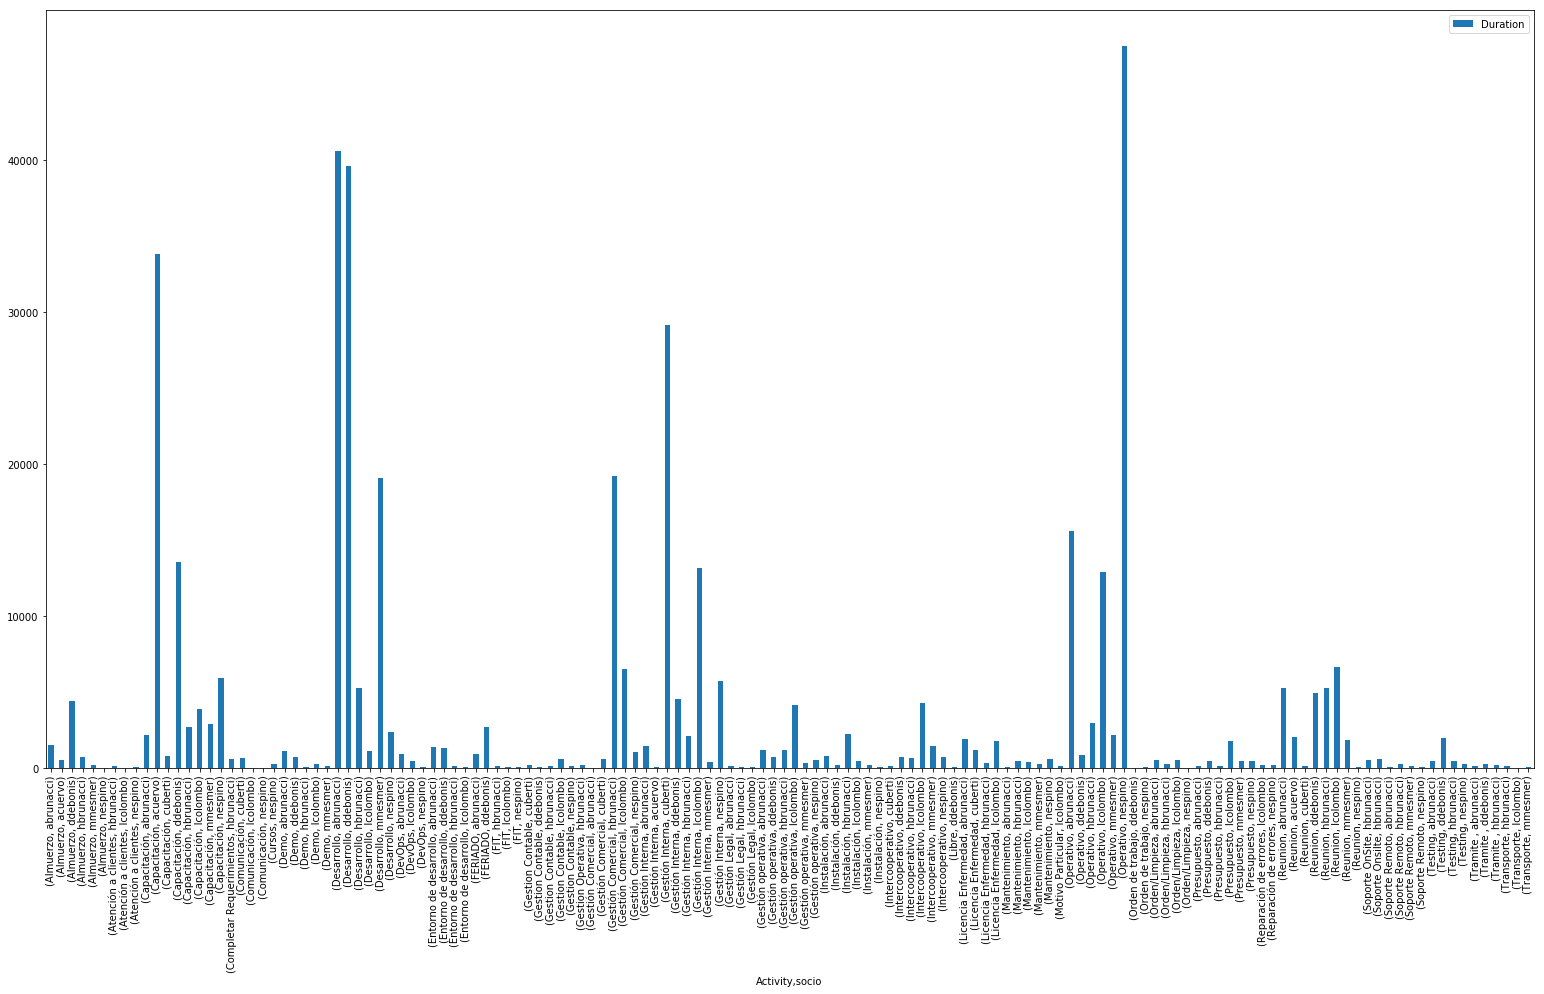

In [164]:
%pylab
# Make the graphs a bit prettier, and bigger
# pd.set_option('display.mpl_style', 'default') 
pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 60) 

figsize(15, 5)
activity.plot(kind='bar')

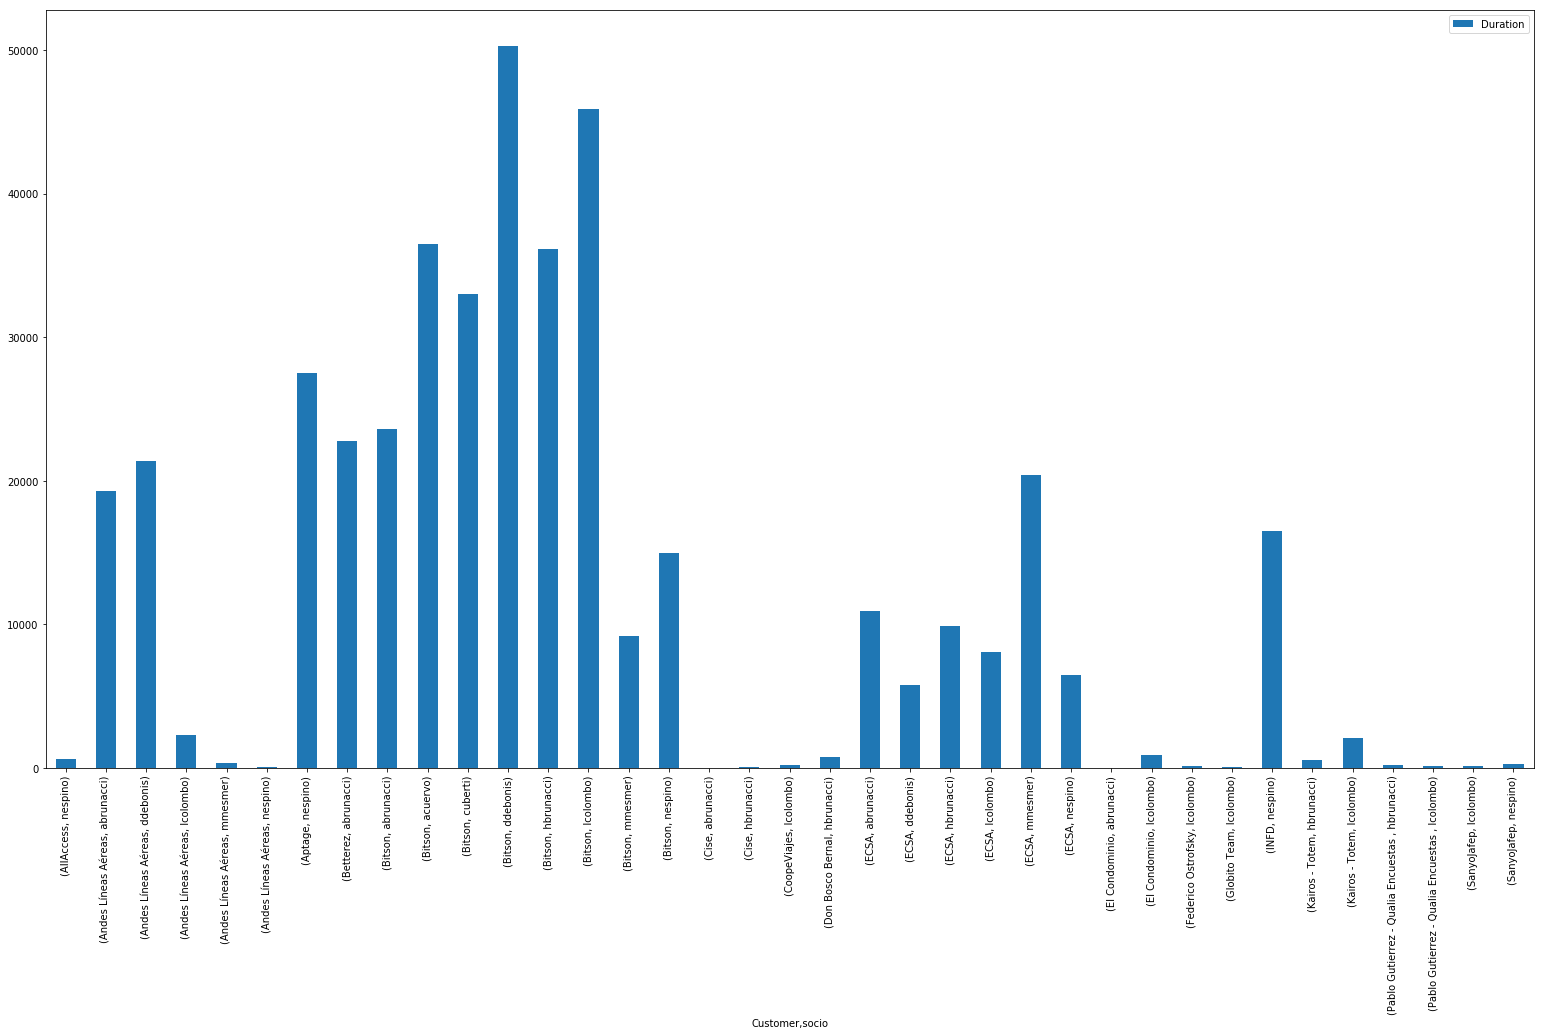

In [165]:
customer.plot(kind='bar')

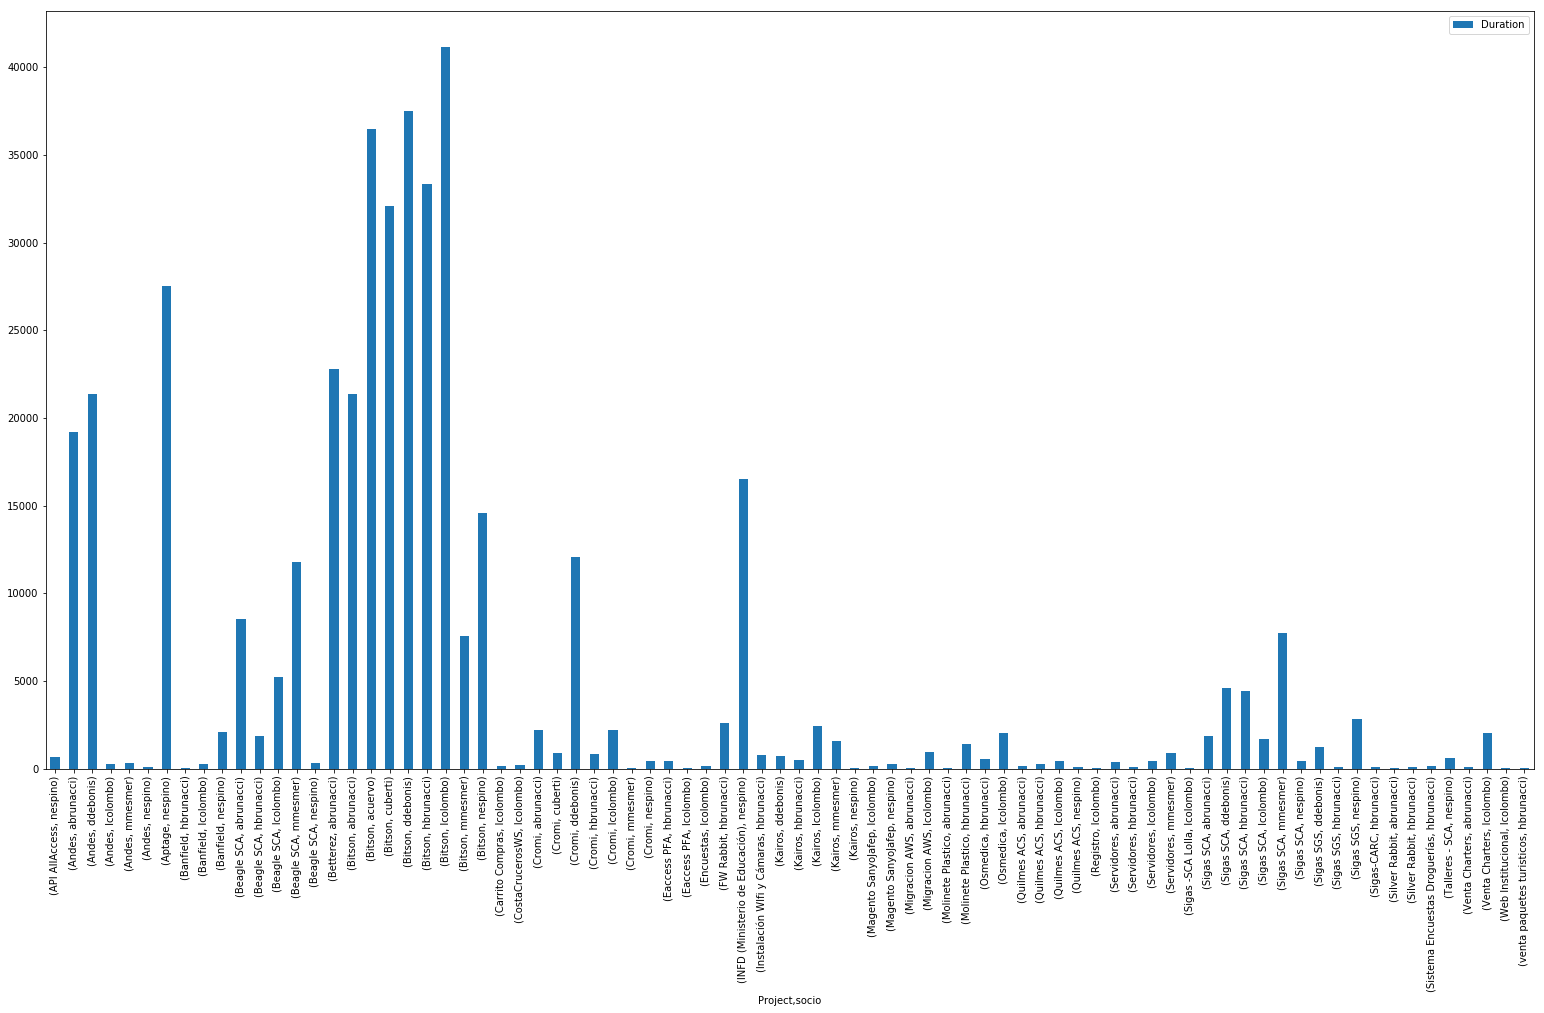

In [166]:
project.plot(kind='bar')

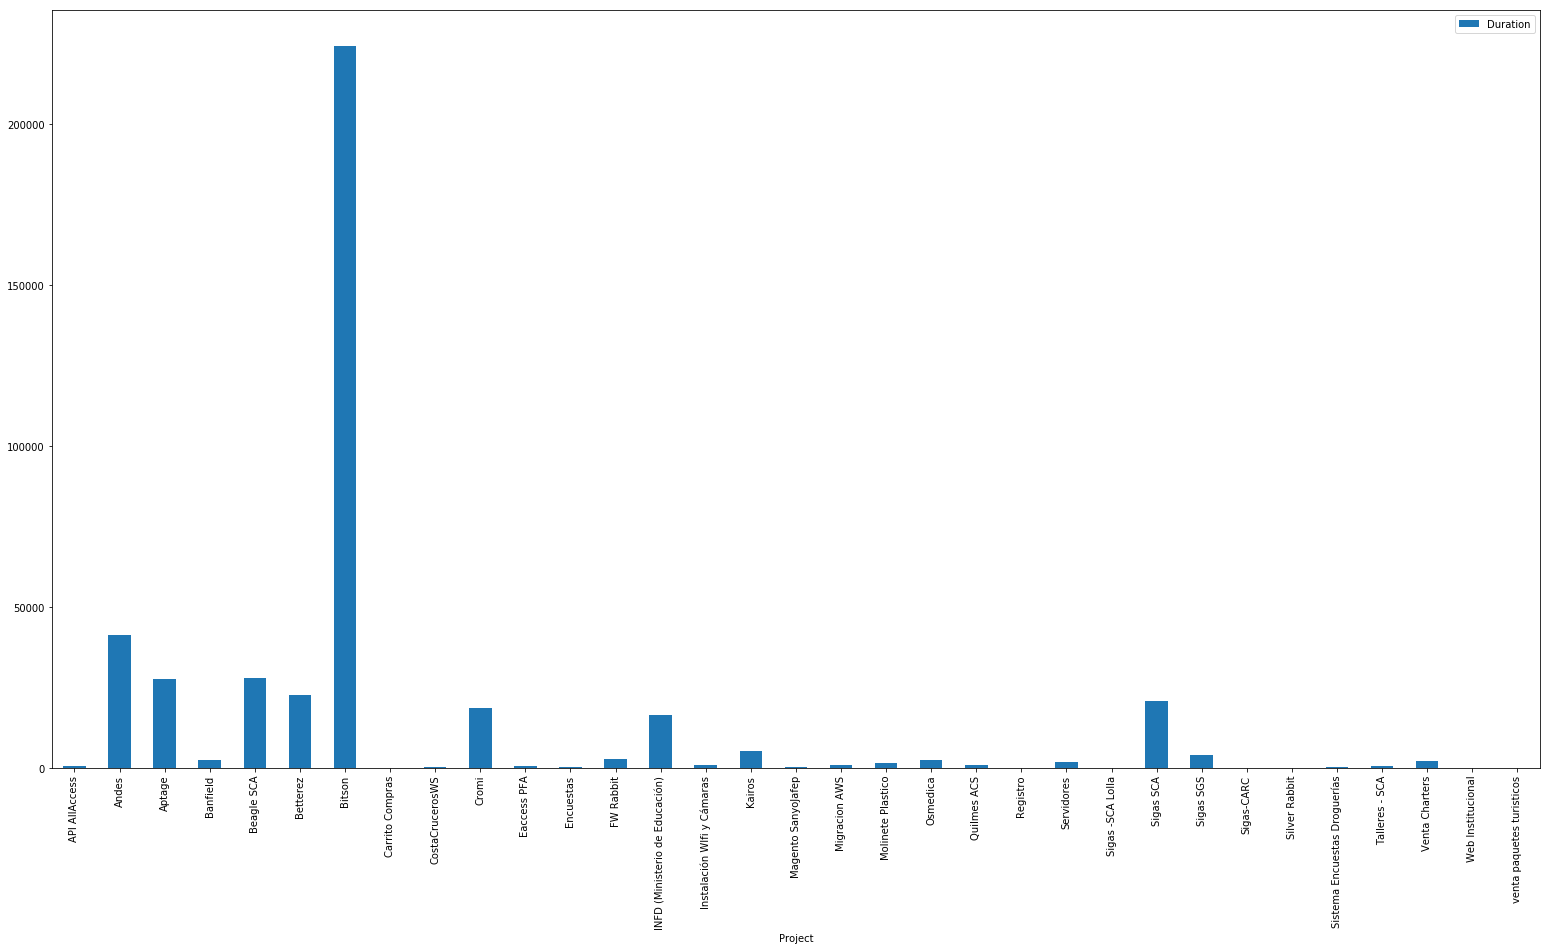

In [167]:
project.groupby(['Project']).sum().plot(kind='bar')

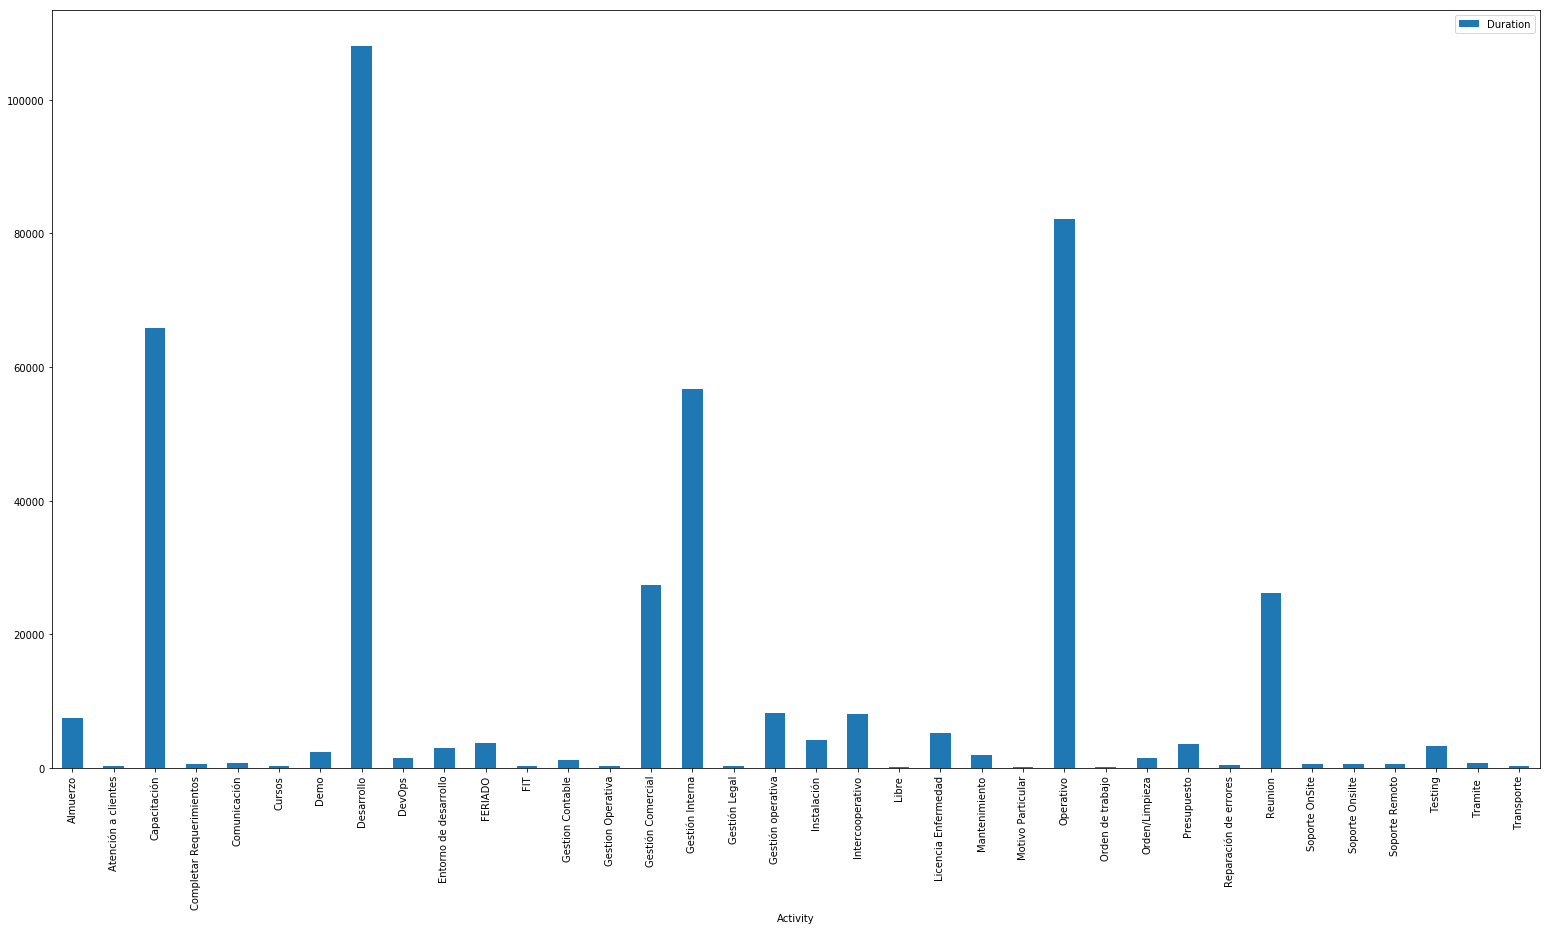

In [168]:
activity.groupby(['Activity']).sum().plot(kind='bar')

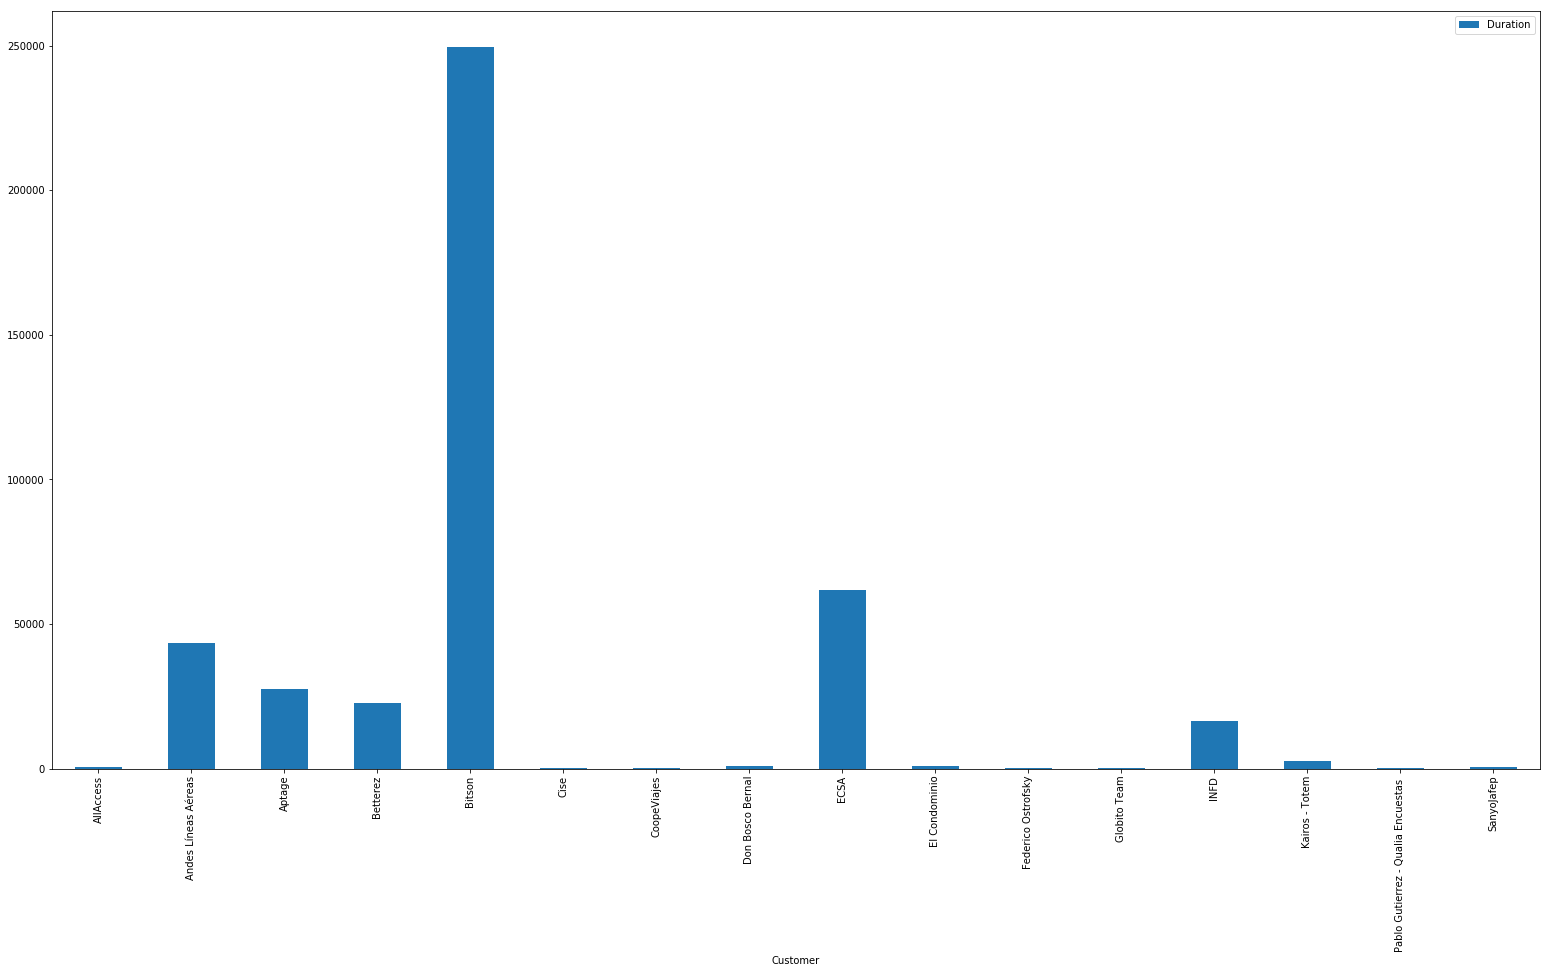

In [169]:
customer.groupby(['Customer']).sum().plot(kind='bar')